### Run Prediction on Test Data

In [1]:
from modules_lib.model import ModelWrapper
%load_ext autoreload
%autoreload 2
import sys
import os
# Laptop GPU is busy with rendering screen ...
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  
import pickle
import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

home_path = '/home/irfan-flw/6GEM/Coding/Vicon_Pos_Converter/'
os.chdir(home_path)

#model_file_i = 'data/models/model_coords_0002_with_all_do' # model_coords_0000_do_005 model_coords_0002 model_coords_0000_10epoch model_coords_0001_with_all_do
model_file_i = 'data/models/model_per_epoch/model_coords_03/model_21' #model_coords_03/model_20 21 29#model_coords_01_with_r4/model_10


model_wrapper = ModelWrapper(model_file_i)


2022-11-01 17:23:30.108549: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-01 17:23:31.863623: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-01 17:23:31.863695: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (irfanflw-XPS-15-9510): /proc/driver/nvidia/version does not exist
2022-11-01 17:23:31.864772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the

Loaded Model with settings:
	add_coordinates: True
	sensor_norm_file: data/normalization/sensor_normalization_eqFalse_trTrue_24102022_with_r4.pkl


In [2]:
# home_path = '/home/irfan-flw/6GEM/Coding/Vicon_Pos_Converter/'
# os.chdir(home_path)

vicon_file = 'vicon_node_positions.csv'
df_vicon = pd.read_csv(vicon_file)

# get arrays of coordinates
vicon_coords = np.empty([23, 15, 2])
for strip_id in range(1, 24):
    for node_id in range(1, 16):
        mask = np.logical_and(
            df_vicon['strip_id'] == strip_id,
            df_vicon['node_id'] == node_id)
        vicon_coords[strip_id-1, node_id-1, 0] = df_vicon.vicon_x[mask]
        vicon_coords[strip_id-1, node_id-1, 1] = df_vicon.vicon_y[mask]
print(df_vicon.min())
print(df_vicon.max())
print(df_vicon.node_id.size, 23*15)
df_vicon.head()

strip_id     1.000
node_id      1.000
vicon_x    -11.185
vicon_y     -6.425
dtype: float64
strip_id    23.000
node_id     15.000
vicon_x     10.815
vicon_y      7.575
dtype: float64
345 345


,strip_id,node_id,vicon_x,vicon_y
0,1.0,1.0,-11.185,7.575
1,1.0,2.0,-11.185,6.575
2,1.0,3.0,-11.185,5.575
3,1.0,4.0,-11.185,4.575
4,1.0,5.0,-11.185,3.575


In [3]:
#from modules_lib.data import read_data
from modules_lib.data import KEYS as keys
from modules_lib.data import get_data_from_data_frame
from modules_lib.data import read_data

path_dataset = '/media/irfan-flw/DATA/Arbeit/6GEM/Program_Development/6GEM_Dataset/Dataset_Sensor_Floor_Final/24102022/test/'

os.chdir(path_dataset)

#offset = 2459828.75 #2459794.5 Julian epoch for 03.08.2022//Julian epoch for 5th August 2020: 2459067.00
#20oct 06.19: 2459872.7636814(test_6_4) 9.20: 2459872.8888889(test_run) 11.10: 2459872.96528; 8.06:2459872.8379869, 2459872.9311315 #2459852.96875 #offset 11.15 #2459853.05556 
#30.09 13.20 #2459824.95833 6.10 2459872.76389 10.02: 2459852.918653 2459852.9166667
offset =  2459877.0729167 #2459872.7636814  #2459872.8888889 #2459852.9166667 #2459872.75

#frames_test, y_test, t_test, X_test = read_data(test_file)
frames_test, y_test, t_test, X_test = read_data('test_data.csv', offset)

  0%|          | 0/3170 [00:00<?, ?it/s]

In [4]:
import json

# home_path = '/home/irfan-flw/6GEM/Coding/Vicon_Pos_Converter/'
# os.chdir(home_path)

os.chdir(path_dataset)
#df_pred = pd.DataFrame(pred_data, columns=['X','Y'])
df_gt = pd.read_csv('test_data_gt.csv')
df_gt

,frame_number,vicon_x,vicon_y
0,0,-6.837469,-2.419369
1,1,-6.837134,-2.419645
2,2,-6.836970,-2.419634
3,3,-6.837237,-2.419625
4,4,-6.837443,-2.419417
...,...,...,...
3165,3165,0.364044,0.109141
3166,3166,0.364073,0.109189
3167,3167,0.364074,0.109108
3168,3168,0.364052,0.109187


**Check the real time prediction file**

In [63]:
import json

home_path = '/home/irfan-flw/6GEM/Coding/Vicon_Pos_Converter/'
os.chdir(home_path)

pred_data = []
# for line in open('test_prediction_2810_test_run2.txt', "r"):
#     pred_data.append(json.loads(line))

# df_pred = pd.DataFrame(pred_data, columns=['timestamp','X','Y'])
df_pred = pd.read_csv("test_prediction_2810_test_run3.txt", sep=", ", header=None, 
                 names=["timestamp","X", "Y"])
df_pred

/tmp/ipykernel_10672/3676091225.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_pred = pd.read_csv("test_prediction_2810_test_run3.txt", sep=", ", header=None,


,timestamp,X,Y
0,1.666969e+09,-4.424383,-2.311078
1,1.666969e+09,-4.424383,-2.311078
2,1.666969e+09,-4.426000,-2.312019
3,1.666969e+09,-4.425633,-2.310913
4,1.666969e+09,-4.425547,-2.311904
...,...,...,...
1667,1.666969e+09,-2.459183,-2.985914
1668,1.666969e+09,-2.475995,-2.960740
1669,1.666969e+09,-2.478251,-2.961688
1670,1.666969e+09,-2.479838,-2.960258


***Synchronize timestamp of prediction data and test dataset***

In [64]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    #print(np.abs(array - value), len(np.abs(array - value)))
    return idx

#closest_index_vicon = []
closest_index = []

num_predicts = len(df_pred.timestamp)

#for i in range(len(timestamp_merge_arr)):
for i in range(num_predicts):
    pos = df_pred.timestamp[i]
    #index_vicon = find_nearest(dataSet_vc[2], pos)
    index = find_nearest(df_gt.time, pos)

    #closest_index_vicon.append(index_vicon)
    closest_index.append(index)

print(len(closest_index), closest_index)

1672 [37, 38, 39, 41, 42, 43, 44, 45, 46, 48, 49, 76, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 107, 108, 109, 111, 112, 114, 115, 116, 117, 119, 120, 121, 122, 123, 124, 126, 127, 128, 130, 131, 132, 133, 135, 136, 137, 139, 140, 141, 142, 144, 145, 146, 147, 149, 151, 152, 153, 155, 156, 157, 159, 160, 161, 162, 163, 165, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 212, 213, 214, 215, 216, 217, 218, 219, 221, 222, 223, 224, 226, 227, 229, 230, 231, 232, 233, 235, 236, 237, 238, 240, 241, 242, 243, 244, 246, 247, 248, 249, 251, 252, 253, 254, 256, 257, 258, 259, 261, 262, 264, 265, 266, 267, 269, 270, 271, 272, 274, 275, 276, 277, 279, 280, 281, 282, 311, 312, 313, 314, 315, 316, 318, 319, 320, 321, 322, 323, 324, 326, 327, 328, 329, 330, 331, 333, 334, 335, 336, 338, 339, 340, 341, 342, 344, 345, 346, 348, 349, 350, 351, 353, 354, 355, 356, 358, 359, 360, 361, 363, 364, 365, 366, 369, 3

In [65]:
df_gt_filter = df_gt.iloc[closest_index]
df_gt_filter = df_gt_filter.reset_index(drop=True)
df_gt_filter

,frame_number,time,vicon_x,vicon_y
0,37,1.666969e+09,-4.332222,-2.594437
1,38,1.666969e+09,-4.332275,-2.594507
2,39,1.666969e+09,-4.332028,-2.594921
3,41,1.666969e+09,-4.332183,-2.594498
4,42,1.666969e+09,-4.332242,-2.594446
...,...,...,...,...
1667,2201,1.666969e+09,-2.933015,-3.137262
1668,2201,1.666969e+09,-2.933015,-3.137262
1669,2201,1.666969e+09,-2.933015,-3.137262
1670,2201,1.666969e+09,-2.933015,-3.137262


In [66]:
df_merge = pd.concat([df_pred, df_gt_filter], axis=1)

df_merge

,timestamp,X,Y,frame_number,time,vicon_x,vicon_y
0,1.666969e+09,-4.424383,-2.311078,37,1.666969e+09,-4.332222,-2.594437
1,1.666969e+09,-4.424383,-2.311078,38,1.666969e+09,-4.332275,-2.594507
2,1.666969e+09,-4.426000,-2.312019,39,1.666969e+09,-4.332028,-2.594921
3,1.666969e+09,-4.425633,-2.310913,41,1.666969e+09,-4.332183,-2.594498
4,1.666969e+09,-4.425547,-2.311904,42,1.666969e+09,-4.332242,-2.594446
...,...,...,...,...,...,...,...
1667,1.666969e+09,-2.459183,-2.985914,2201,1.666969e+09,-2.933015,-3.137262
1668,1.666969e+09,-2.475995,-2.960740,2201,1.666969e+09,-2.933015,-3.137262
1669,1.666969e+09,-2.478251,-2.961688,2201,1.666969e+09,-2.933015,-3.137262
1670,1.666969e+09,-2.479838,-2.960258,2201,1.666969e+09,-2.933015,-3.137262


In [67]:
df_merge.to_csv('test_run3_merge.csv')

In [68]:
X_test_filter = np.zeros([len(df_gt_filter), 23, 15, 10])
t_test_filter = np.zeros([len(df_gt_filter), 1])
cnt = 0

for index in range(len(X_test)):

    if index in closest_index:
       
        #print(df_data)
        #index_assoc = closest_index.index(index)
        #print(cnt, index, index_assoc)

        X_test_filter[cnt] = X_test[index]
        t_test_filter[cnt] = t_test[index]
        cnt += 1
print(X_test_filter.shape, t_test_filter.shape)

(1672, 23, 15, 10) (1672, 1)


***Test predict 1 sample***

In [ ]:
X_input_test = np.reshape(X_test[100], [-1, 23, 15, 10])
t_input_test = np.reshape(t_test[100], [-1, 1])
mu = model_wrapper.predict(X_input_test, t_input_test, run_post_processing=True, check_data=True)
#mu_iter = model_wrapper.predict_iteratively(X_test[900:1150], t_test[900:1150],run_post_processing=True, check_data=True)
#mu = model_wrapper.predict(X_input_test, t_input_test)
print(mu)

***Test predict the whole samples***

In [5]:
#test predict
#missing nodes: 7-13, 20-9, 21-6, 23-5

#mu = model_wrapper.predict(X_test_filter, t_test_filter, run_post_processing=True, check_data=True)
mu = model_wrapper.predict(X_test, t_test, run_post_processing=True, check_data=True)
#mu_iter = model_wrapper.predict_iteratively(X_test[900:1150], t_test[900:1150],run_post_processing=True, check_data=True)
#mu = model_wrapper.predict(X_input_test, t_input_test)
print(mu)


X_shape predict: (3170, 23, 15, 10)
Mean failed:
Std failed:
=== Test Failed ===
[WARNING]: Check if data format/calibration is correct!
X out1:  (3170, 23, 15, 10)
100/100 [==============================] - 1s 6ms/step


/home/irfan-flw/6GEM/Coding/Vicon_Pos_Converter/modules_lib/model.py:813: RuntimeWarning: overflow encountered in exp
  np.exp(0 + reg_hard*acc_abs),
/home/irfan-flw/6GEM/Coding/Vicon_Pos_Converter/modules_lib/model.py:814: RuntimeWarning: overflow encountered in exp
  np.exp(offset + reg_soft*acc_abs),
/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: nan
 hess_inv: <6340x6340 LbfgsInvHessProduct with dtype=float64>
      jac: array([nan, nan, nan, ..., nan, nan, nan])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 133161
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([-6.84443855, -2.11061811, -6.8420763 , ...,  0.10765453,
        0.37666139,  0.1133125 ])
[[-6.84443855 -2.11061811]
 [-6.8420763  -2.12675405]
 [-6.78623104 -2.16883469]
 ...
 [ 0.39591035  0.10279367]
 [ 0.4084982   0.10765453]
 [ 0.37666139  0.1133125 ]]


In [27]:
#import numpy as np
# --------
# settings
# --------
norm_use_training_data = True
treat_sensors_equally = False
# --------

home_path = '/home/irfan-flw/6GEM/Coding/Vicon_Pos_Converter/'
os.chdir(home_path)

if treat_sensors_equally:
    norm_axes = (0, 1, 2)
else:
    norm_axes = 0

sensor_norm = np.zeros_like(X_test[0][0])
num_frames = 0
X_concat = np.concatenate(X_test, axis=0)
sensor_bias = np.nanmean(
    X_concat, axis=norm_axes, keepdims=True)[0]
sensor_std = np.nanstd(
    X_concat, axis=norm_axes, keepdims=True)[0] + 1e-7
# print('Total number of frames:', X_concat.shape[0])
# print(sensor_bias.shape)
# print(sensor_std.shape)


# with open('data/normalization/norm_data_00000100.pkl', 'rb') as handle:
with open('data/normalization/sensor_normalization_eqFalse_trTrue_30092022_V2.pkl', 'rb') as handle:
    t_norm, X_norm = pickle.load(handle, encoding='latin1')
    sensor_bias2 = np.nanmean(
        X_norm, axis=norm_axes, keepdims=True)[0]
    sensor_std2 = np.nanstd(
        X_norm, axis=norm_axes, keepdims=True)[0] + 1e-7
    t_diff = np.diff(t_norm, axis=0)
    #plt.hist(t_diff, bins=30)
    
# print(np.nanmean(X_concat, axis=(0, 1, 2)))
# print(np.nanmean(X_norm, axis=(0, 1, 2)))

# print(np.nanstd(X_concat, axis=(0, 1, 2)))
# print(np.nanstd(X_norm, axis=(0, 1, 2)))

# save sensor normalization
if norm_use_training_data:
    pass
else:
    sensor_bias = sensor_bias2
    sensor_std = sensor_std2
    
# sensor_norm_file = 'data/normalization/sensor_normalization_eq{}_tr{}_09092022.pkl'.format(
#     treat_sensors_equally, norm_use_training_data)
sensor_norm_file = 'data/normalization/sensor_normalization_eqFalse_trTrue_30092022_V2.pkl'.format(
    treat_sensors_equally, norm_use_training_data)
if os.path.exists(sensor_norm_file):
    print('WARNING: File {} already exists. Aborting!'.format(
        sensor_norm_file))
else:
    with open(sensor_norm_file, 'wb') as handle:
        pickle.dump([sensor_bias, sensor_std], 
                    handle, protocol=3)

print('Sensor normalization file:', sensor_norm_file)


Sensor normalization file: data/normalization/sensor_normalization_eqFalse_trTrue_30092022_V2.pkl


In [ ]:
# from modules_lib.model import likelihood, postprocess
# from modules_lib.data import get_vel_and_acc, append_vicon_coords

# add_coordinates = True

# for normalized in [True]:
#     for run in range(7, 9):
#         print('Creating Run {} with normalization {}'.format(
#             run, normalized))
        
#         # get data
#         t_data = np.array(t_test[run])
#         X_data = np.array(X_test[run])
#         y_true = np.array(y_test[run])
        
#         # limit data and frequency
#         num_frames = 100
#         start = 0
#         every_nth = 2
#         t_data = t_data[::every_nth][start:start + num_frames]
#         y_true = y_true[::every_nth][start:start + num_frames]
#         X_data = X_data[::every_nth][start:start + num_frames]
        
#         # run ModelWrapper prediction before we alte the
#         # data tensors
#         mu_wrapper = model_wrapper.predict(X_data, t_data, run_post_processing=True)
        
#         X_data = (X_data - sensor_bias) / sensor_std
#         X_data[~np.isfinite(X_data)] = 0
#         #X_data, y_true = flip_along_y_axis(X_data, y_true)
#         #X_data, y_true = shift_columns(X_data, y_true, n=15)
#         X_data = X_data[..., 6:]
        
#         if add_coordinates:
#             X_data = append_vicon_coords(X_data)

#         y_pred = model_wrapper.predict(X_data)

#         # undo normalization of y_pred during training
#         # y_pred *= 10.
        
#         mu = y_pred[..., :2]
#         sigma = y_pred[..., 2:4]
#         r = y_pred[..., 4:]
        
#         # Run Evaluation
#         print('Plain Model Prediction')
#         print(np.mean(np.sum(np.sqrt((mu - y_true)**2), axis=1)))
#         vel, acc = get_vel_and_acc(mu, t_data)[:2]
#         print(np.max(vel), np.max(acc))
        
#         if False:
#             mu = postprocess(mu, sigma, r, t_data, 
#                              pre_fitting_size=None)

#             # Run Evaluation
#             print('After Post-Processing')
#             print(np.mean(np.sum(np.sqrt((mu - y_true)**2), axis=1)))
#             print(np.mean((mu - y_true)**2))
#             vel, acc = get_vel_and_acc(mu, t_data)[:2]
#             print(np.max(vel), np.max(acc))
        
#         # Run Evaluation
#         print('Model Wrapper Class')
#         print(np.mean(np.sum(np.sqrt((mu_wrapper - y_true)**2), axis=1)))
#         print(np.mean((mu_wrapper - y_true)**2))
#         vel, acc = get_vel_and_acc(mu_wrapper, t_data)[:2]
#         print(np.max(vel), np.max(acc))
        
#         if False:
#             create_complete_gif2(
#                 run, normalized=normalized, num_frames=num_frames,
#                 y_pred=mu,
#             )

In [ ]:
# import seaborn as sns

# rssi_mat = X_test[450,:,:,9]
# fig = plt.figure(figsize=(14, 12))
          
# ax1 = fig.add_subplot(211)
# #ax1 = plt.subplots(figsize=(10,7))
# ax1 = sns.heatmap(rssi_mat, annot=False, cbar_kws={'label': 'RSSI'}, cmap="YlGnBu")
# #ax1 = sns.heatmap(sensor_data[:,:,9], annot=False, cbar_kws={'label': 'RSSI'}, cmap="YlGnBu")
# ax1.figure.axes[-1].yaxis.label.set_size(14)
       
# plt.title("RSSI Heatmap", fontsize = 16)
# plt.ylabel("Node ID", fontsize = 16)
# plt.xlabel("Strip ID", fontsize = 16)

# ax2 = fig.add_subplot(212)
# plt.xlim(-11.185, 10.185)
# plt.ylim(-6.425, 7.575)
# plt.title("Trajectory of robot", fontsize = 16)
# plt.ylabel("Y(t)", fontsize = 16)
# plt.xlabel("X(t)", fontsize = 16)
# plt.plot(y_test[:,0], y_test[:,1], label='Ground Truth', color='red')

Text(0.5, 1.0, 'Prediction vs Ground Truth')

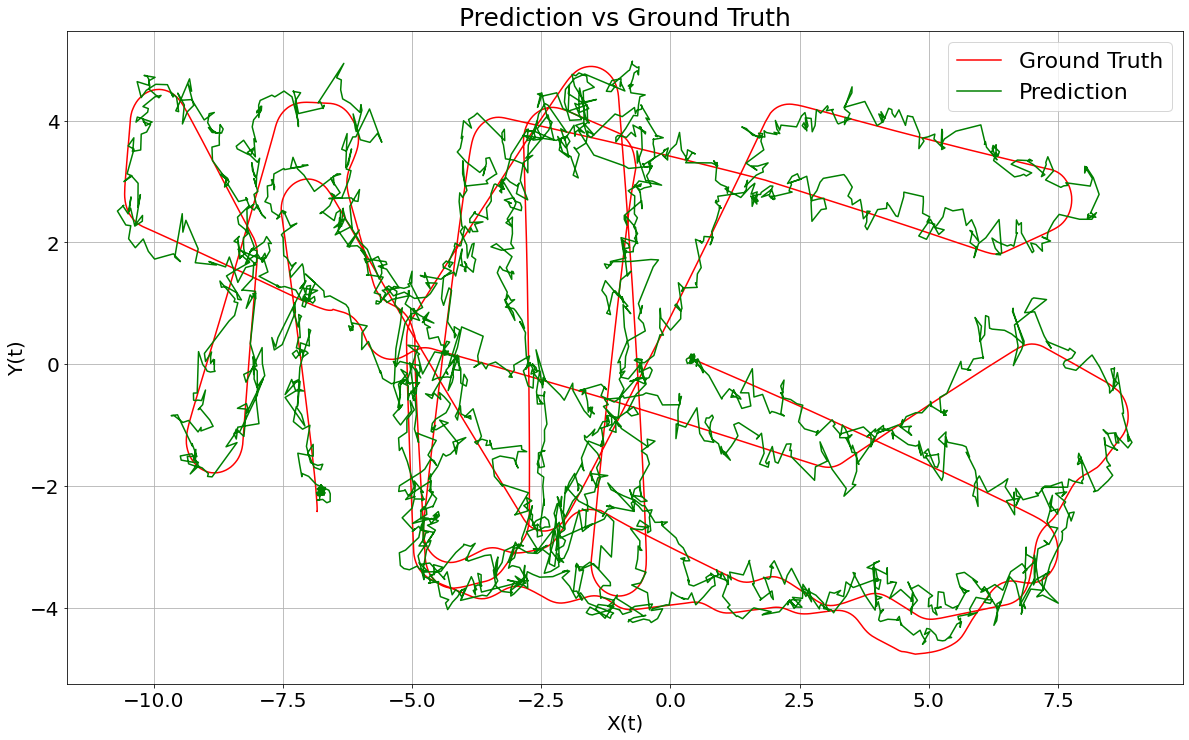

In [6]:
from turtle import color
from matplotlib import pyplot as plt

lower_thres = 0
upper_thres = 3169#1672
offset_data = 0

fig = plt.figure(figsize=(20, 12))

plt.plot(df_gt.vicon_x[lower_thres:upper_thres], df_gt.vicon_y[lower_thres:upper_thres], label='Ground Truth', color='red')
plt.plot(mu[lower_thres:upper_thres,0], mu[lower_thres:upper_thres,1], label = 'Prediction', color='green')
#plt.scatter(df_vicon.vicon_x, df_vicon.vicon_y, label = 'Node Grids')
#plt.plot(df_pred.X[lower_thres+offset_data:upper_thres+offset_data], df_pred.Y[lower_thres+offset_data:upper_thres+offset_data], label = 'Prediction-RT', color='orange')
#plt.plot(mu_iter[:,0], mu_iter[:,1], label = 'Prediction_Iter')
# plt.xlim(-11.185, 10.185)
# plt.ylim(-6.425, 7.575)
plt.xlabel('X(t)', fontsize = 20)
plt.ylabel('Y(t)', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(loc='upper right', fontsize = 22)
plt.title('Prediction vs Ground Truth', fontsize=25)

In [7]:
home_path = '/home/irfan-flw/6GEM/Coding/Vicon_Pos_Converter/'
os.chdir(home_path)
fig.savefig('output/plot_predict/predict_model_003_epoch_21_test_data.jpg', dpi=300, transparent=False)

Text(0.5, 1.0, 'Prediction vs Ground Truth')

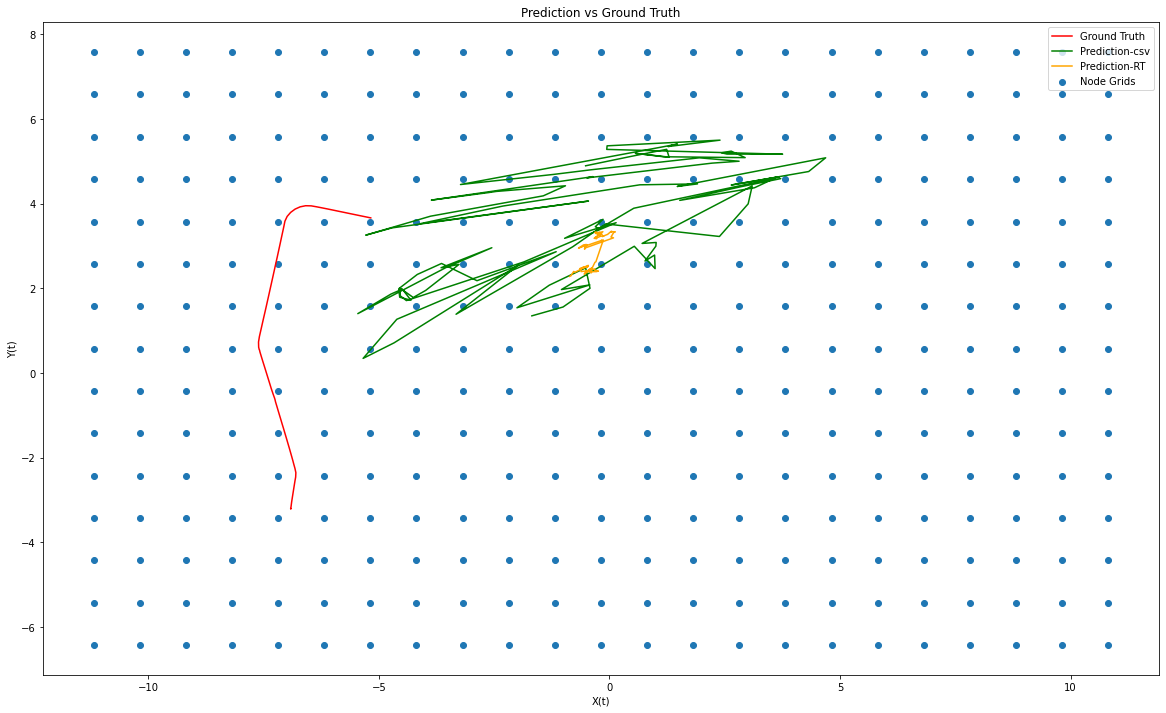

In [25]:
from turtle import color
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20, 12))

lower_thres = 300
upper_thres = 400

plt.plot(y_test[lower_thres:upper_thres,0], y_test[lower_thres:upper_thres,1], label='Ground Truth', color='red')
#plt.scatter(mu[:,0], mu[:,1], label = 'Prediction', color='green')
plt.plot(mu[lower_thres:upper_thres,0], mu[lower_thres:upper_thres,1], label = 'Prediction-csv', color='green')
plt.plot(df_pred.X[lower_thres:upper_thres], df_pred.Y[lower_thres:upper_thres], label = 'Prediction-RT', color='orange')
plt.scatter(df_vicon.vicon_x, df_vicon.vicon_y, label = 'Node Grids')
#plt.scatter(cell[:,0], cell[:,1], label = 'Predicted Grids', color='orange')
#plt.plot(mu_iter[:,0], mu_iter[:,1], label = 'Prediction_Iter')
# plt.xlim(-11.185, 10.185)
# plt.ylim(-6.425, 7.575)
plt.xlabel('X(t)')
plt.ylabel('Y(t)')
plt.legend(loc='upper right')
plt.title('Prediction vs Ground Truth')

In [10]:
fig.savefig('data/models/predict_model_coords_002_all_do_test_2410.jpg', dpi=300, transparent=False)

In [ ]:
num_frames = 100
use_wrapper = True

y_test_pred = []

for split in tqdm(range(len(X_test_list))):
    X_test_i = np.array(X_test_list[split])
    t_test_i = np.array(t_test_list[split])
    y_test_i = np.array(y_test_list[split])
    
    if use_wrapper:
        mu = model_wrapper.predict(X_test_i, t_test_i)
    else:

        X_test_norm_i = np.array((X_test_i - sensor_bias) / sensor_std)
        X_test_norm_i[~np.isfinite(X_test_norm_i)] = 0
        X_test_norm_i = X_test_norm_i[..., 6:]

        y_test_pred_i = model.predict(X_test_norm_i)

        mu = y_test_pred_i[..., :2]
        sigma = y_test_pred_i[..., 2:4]
        r = y_test_pred_i[..., 4:]

        # Run Evaluation
        vel, acc = get_vel_and_acc(mu, t_test_i)[:2]
        print(np.max(vel), np.max(acc))

        mu = postprocess(mu, sigma, r, t_test_i, 
                         pre_fitting_size=None)

    # Run Evaluation
    vel, acc = get_vel_and_acc(mu, t_test_i)[:2]
    print(np.max(vel), np.max(acc))
    
    # append reconstructed positions to list
    y_test_pred.append(mu)
    
    
y_test_pred = np.concatenate(y_test_pred, axis=0)

if False:
    create_complete_gif2(
        run, 
        file_name='plots/gif_test_{norm}.gif',
        normalized=True, num_frames=num_frames,
        y_pred=y_test_pred,
    )

In [ ]:
# print(len(y_test_pred), len(X_test))
# assert len(y_test_pred) == len(X_test), len(y_test_pred)

# data_dict = {
#     'frame_number': range(len(y_test_pred)),
#     'vicon_x': y_test_pred[:, 0],
#     'vicon_y': y_test_pred[:, 1],
# }

# df_test_pred = pd.DataFrame(data_dict)
# df_test_pred = df_test_pred.set_index('frame_number')
# print(df_test_pred.head())

# test_pred_file = 'data/test_submission_{}_{:03d}.csv'
# for i in range(1000):
#     test_pred_file_i = test_pred_file.format(
#         os.path.basename(model_file_i), i)
#     if not os.path.exists(test_pred_file_i):
#         print('Saving prediction to:', test_pred_file_i)
#         df_test_pred.to_csv(test_pred_file_i)
#         break

#### Check Resolution

In [ ]:
t_test_pred = []
for split in tqdm(range(len(X_test_list))):
    t_test_i = np.array(t_test_list[split])
    t_test_pred.append(t_test_i)
t_test_pred = np.concatenate(t_test_pred, axis=0)

# get velocity and acceleration
vel_abs, acc_abs, acc_parallel, acc_perp = \
    get_vel_and_acc(y_test_pred, t_test_pred)

plt.figure(figsize=(64, 4))
plt.plot(vel_abs, label='|Velocity|')
plt.plot(acc_abs, label='|Acceleration|')
plt.axhline(np.max(vel_abs), ls='--', color='0.6', 
           label='Max Vel.: {:3.3f}'.format(np.max(vel_abs)))
plt.axhline(np.max(acc_abs), ls='--', color='0.6', 
           label='Max Acc.: {:3.3f}'.format(np.max(acc_abs)))
plt.axhline(.707, ls='-', color='.8', label='Reference: 707')
plt.axhline(.717, ls='-', color='.8', label='Reference: 717')
plt.legend()
plt.show()
    

In [ ]:
create_y_gif(
    y_pred=y_test_pred[::5], 
    y_true=None, 
    file_name='plots/gif_y_prediction.gif')